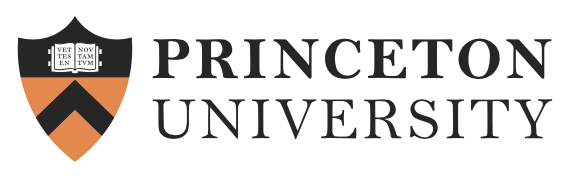

# AwkwardArrays in Julia for High-Energy Physics Data Analysis

AwkwardArrays are designed to handle irregular, nested data structures with Python being the primary language

 * [Reading RNTuple data with Uproot](https://ariostas-talks.github.io/2024-07-02-pyhep-uproot-rntuple/lab/index.html) by Andres Rios-Tascon
 * [Distributed Columnar HEP analysis using coffea + dask](https://github.com/ikrommyd/pyhep2024-coffea-dask) by Iason Krommydas
 * Easy Columnar File Conversion with ‘hepconvert' by Zoë Bilodeau
 * A new SymPy backend for vector: uniting experimental and theoretical physicists by Saransh Chopra

Recent integration [AwkwardArray.jl](https://github.com/JuliaHEP/AwkwardArray.jl) into Julia offers new possibilities


## Why Julia?

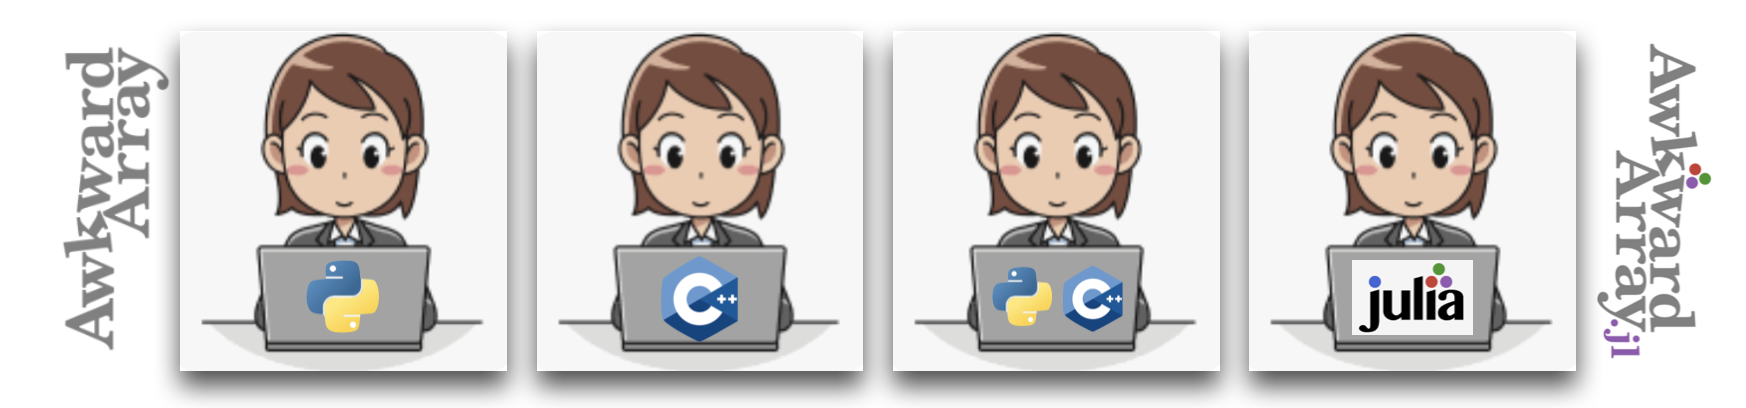

Sharing Awkward Array data structures between Python and Julia to encourage the Python users to run their analysis both in an eco-system of their choice and in Julia

Physicists are using Awkward Array in Python and data format conversion is the hardest part of language boundary-hopping

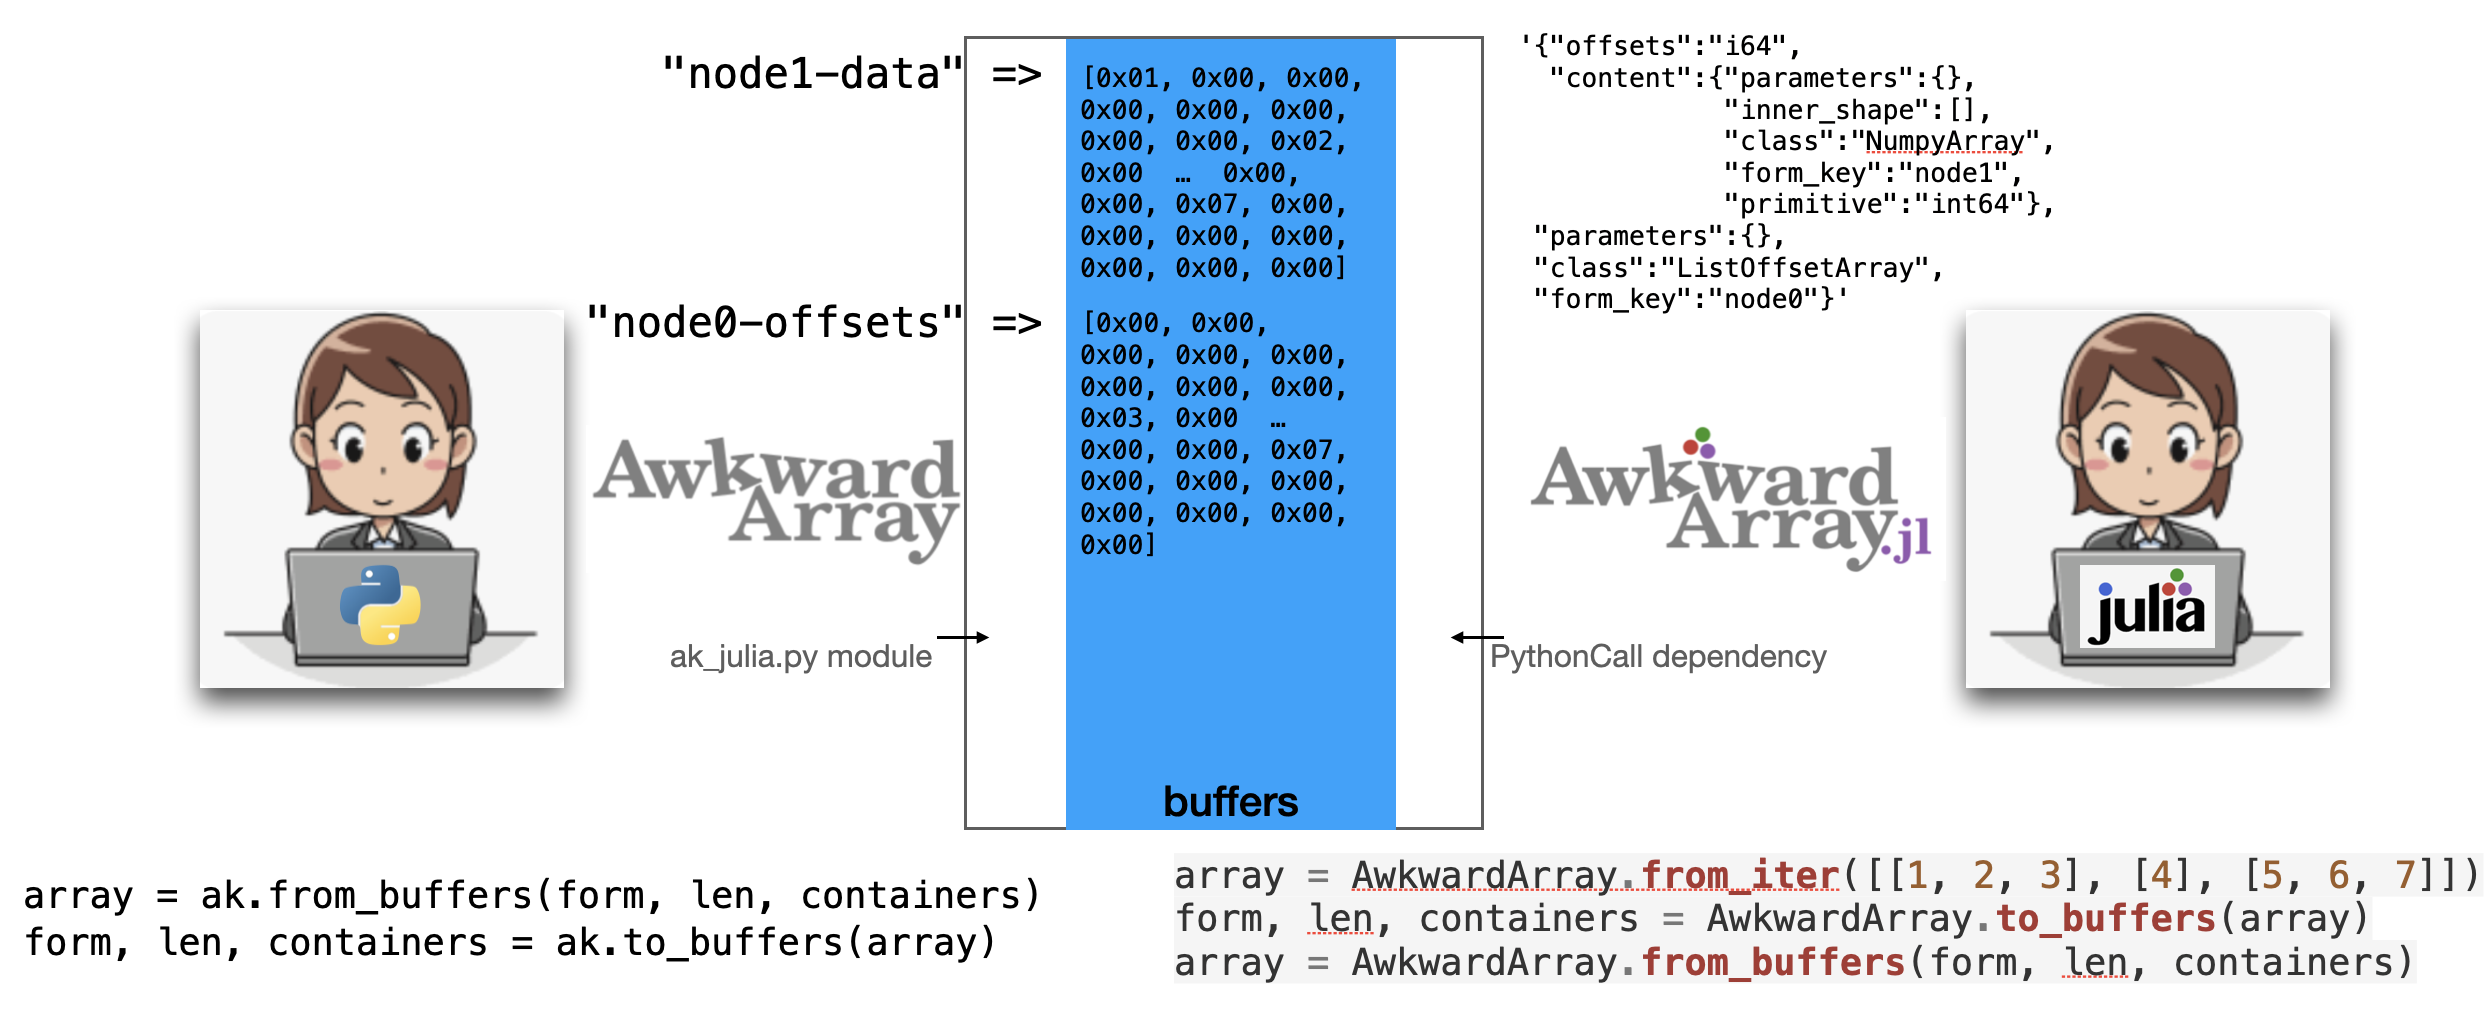

## Installation and Setup

[PythonCall and Julia Call](https://juliapy.github.io/PythonCall.jl/stable/) allow to call Python code from Julia and Julia code from Python via a symmetric interface.

In [1]:
pip install juliacall

Note: you may need to restart the kernel to use updated packages.


In [2]:
from juliacall import Main as jl

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


## Install UnROOT

In [3]:
jl.seval("using Pkg")
jl.seval("Pkg.add(\"UnROOT\")")

   Resolving package versions...
  No Changes to `~/anaconda3/envs/py311-julia19/julia_env/Project.toml`
  No Changes to `~/anaconda3/envs/py311-julia19/julia_env/Manifest.toml`


## Reading data

In [4]:
jl.seval("using UnROOT")

In [5]:
file = jl.Main.ROOTFile("data/SMHiggsToZZTo4L.root")

In [6]:
file

ROOTFile with 1 entry and 18 streamers.
data/SMHiggsToZZTo4L.root
└─ Events (TTree)
   ├─ "run"
   ├─ "luminosityBlock"
   ├─ "event"
   ├─ "⋮"
   ├─ "Electron_dzErr"
   ├─ "MET_pt"
   └─ "MET_phi"


In [7]:
events = jl.Main.LazyTree(file, "Events")

In [8]:
events

 Row │ Electron_mass    nElectron  luminosityBlock  nMuon   Electron_phi     M ⋯
     │ SubArray{Float3  UInt32     UInt32           UInt32  SubArray{Float3  F ⋯
─────┼──────────────────────────────────────────────────────────────────────────
 1   │ []               0          156              3       []               - ⋯
 2   │ [0.00544,        4          156              0       [0.134, -1       2 ⋯
 3   │ [-0.00609,       2          156              0       [2.18, 1.6       - ⋯
 4   │ [-0.00123]       1          156              7       [-0.643]         - ⋯
 5   │ [0.0117, 0       4          156              0       [1.01, -1.       1 ⋯
 6   │ [-0.00183]       1          156              2       [-0.497]         - ⋯
 7   │ [-0.00183]       1          156              1       [-1.47]          - ⋯
 8   │ [-0.00216]       1          156              0       [-0.633]         - ⋯
 9   │ [-0.0128,        4          156              0       [2.79, -2.       - ⋯
 10  │ []               0   

In [9]:
events.Muon_pt

299973-element LazyBranch{SubArray{Float32, 1, Vector{Float32}, Tuple{UnitRange{Int64}}, true}, UnROOT.Nooffsetjagg, ArraysOfArrays.VectorOfVectors{Float32, Vector{Float32}, Vector{Int32}, Vector{Tuple{}}}}: 
 Float32[63.04387, 38.120346, 4.0486875]
 Float32[]
 Float32[]
 Float32[54.33275, 23.515282, 52.871075, 4.328589, 5.3477535, 8.393386, 3.4901235]
 Float32[]
 Float32[38.503757, 47.00221]
 Float32[4.453538]
 Float32[]
 Float32[]
 Float32[]
 ⋮
 Float32[37.18836, 50.064648]
 Float32[43.15527, 23.953928]
 Float32[24.249857, 79.544136]
 Float32[]
 Float32[9.8097515, 25.515368]
 Float32[32.55726, 43.079132]
 Float32[4.3161483, 4.3587666, 5.632667, 4.7507796]
 Float32[]
 Float32[]

In [10]:
type(events)

juliacall.VectorValue

In [11]:
muons_pt = events.Muon_pt
muons_eta = events.Muon_eta
muon_phi = events.Muon_phi
muons_mass = events.Muon_mass
muons_charge = events.Muon_charge
muons_isolation = events.Muon_pfRelIso03_all

In [12]:
type(muons_pt)

juliacall.VectorValue

## Using Julia Functions

In [13]:
jl.seval("""
function my_fun(x,y)
    return 2x.+y
end
""")

my_fun (generic function with 1 method)

In [14]:
jl.my_fun(2,3)

7

## Introducing AwkwardArrays

In [15]:
import awkward as ak

In [16]:
jl.seval("using AwkwardArray")

Let's write a function to convert the UnROOT's LazyBranches into an AwkwardArray in Julia and return the AwkwardArray to Python.

*Note:* Jerry Ling is planning to provide this feature in UnROOT.

In [17]:
jl.seval("""
using AwkwardArray

function make_record_array(events)
    array = AwkwardArray.RecordArray(
        NamedTuple{(:pt, :eta, :phi, :mass, :charge, :isolation)}((
            AwkwardArray.from_iter(events.Muon_pt),
            AwkwardArray.from_iter(events.Muon_eta), 
            AwkwardArray.from_iter(events.Muon_phi), 
            AwkwardArray.from_iter(events.Muon_mass), 
            AwkwardArray.from_iter(events.Muon_charge), 
            AwkwardArray.from_iter(events.Muon_pfRelIso03_all),
        )
    ))
    return AwkwardArray.convert(array)
end
""")

make_record_array (generic function with 1 method)

In [18]:
%%time
muons = jl.make_record_array(events)

CPU times: user 1.48 s, sys: 35.4 ms, total: 1.51 s
Wall time: 1.51 s


In [19]:
%%time
muons = jl.make_record_array(events)

CPU times: user 395 ms, sys: 28.7 ms, total: 424 ms
Wall time: 422 ms


In [20]:
type(muons)

awkward.highlevel.Array

In [21]:
muons

<Array [{pt: [63, ...], eta: [...], ...}, ...] type='299973 * {pt: var * fl...'>

In [22]:
muons.pt

<Array [[63, 38.1, 4.05], [], [], ..., [], []] type='299973 * var * float32'>

In [23]:
%%time
py_muons = ak.zip({
                "pt": muons_pt,
                "eta": events.Muon_eta,
                "phi": events.Muon_phi,
                "mass": events.Muon_mass,
                "charge": events.Muon_charge,
                "isolation": events.Muon_pfRelIso03_all,
            },)

CPU times: user 19.3 s, sys: 191 ms, total: 19.5 s
Wall time: 19.5 s


In [24]:
py_muons

<Array [[{pt: 63, eta: -0.719, ...}, ...], ...] type='299973 * var * {pt: f...'>

## Data Analysis Example 

Thanks to Iason Krommydas' - see his talk for more details.

[Distributed Columnar HEP analysis using coffea + dask](https://github.com/ikrommyd/pyhep2024-coffea-dask) by Iason Krommydas

In [25]:
def find_4lep_kernel(events_leptons, builder):
    """Search for valid 4-lepton combinations from an array of events * leptons {charge, ...}

    A valid candidate has two pairs of leptons that each have balanced charge
    Outputs an array of events * candidates {indices 0..3} corresponding to all valid
    permutations of all valid combinations of unique leptons in each event
    (omitting permutations of the pairs)
    """
    for leptons in events_leptons:
        builder.begin_list()
        nlep = len(leptons)
        for i0 in range(nlep):
            for i1 in range(i0 + 1, nlep):
                if leptons[i0].charge + leptons[i1].charge != 0:
                    continue
                for i2 in range(nlep):
                    for i3 in range(i2 + 1, nlep):
                        if len({i0, i1, i2, i3}) < 4:
                            continue
                        if leptons[i2].charge + leptons[i3].charge != 0:
                            continue
                        builder.begin_tuple(4)
                        builder.index(0).integer(i0)
                        builder.index(1).integer(i1)
                        builder.index(2).integer(i2)
                        builder.index(3).integer(i3)
                        builder.end_tuple()
        builder.end_list()

    return builder


#### This code is translated to Julia by ChatGPT:

In [ ]:
using AwkwardArray

function find_4lep_kernel(events_leptons, builder)
    """
    Search for valid 4-lepton combinations from an array of events * leptons {charge, ...}

    A valid candidate has two pairs of leptons that each have balanced charge.
    Outputs an array of events * candidates {indices 0..3} corresponding to all valid
    permutations of all valid combinations of unique leptons in each event
    (omitting permutations of the pairs).
    """
    for leptons in events_leptons
        builder.begin_list()
        nlep = length(leptons)
        for i0 in 1:nlep
            for i1 in (i0 + 1):nlep
                if leptons[i0].charge + leptons[i1].charge != 0
                    continue
                end
                for i2 in 1:nlep
                    for i3 in (i2 + 1):nlep
                        if length(Set([i0, i1, i2, i3])) < 4
                            continue
                        end
                        if leptons[i2].charge + leptons[i3].charge != 0
                            continue
                        end
                        builder.begin_tuple(4)
                        builder.index(1).integer(i0 - 1)  # Julia is 1-based, subtract 1 for 0-based indexing
                        builder.index(2).integer(i1 - 1)
                        builder.index(3).integer(i2 - 1)
                        builder.index(4).integer(i3 - 1)
                        builder.end_tuple()
                    end
                end
            end
        end
        builder.end_list()
    end

    return builder
end


### Process function

In [26]:
def process(self, events):
        dataset_axis = hist.axis.StrCategory(
            [], growth=True, name="dataset", label="Primary dataset"
        )
        mass_axis = hist.axis.Regular(
            300, 0, 300, name="mass", label=r"$m_{\mu\mu}$ [GeV]"
        )
        pt_axis = hist.axis.Regular(300, 0, 300, name="pt", label=r"$p_{T,\mu}$ [GeV]")

        h_nMuons = hda.Hist(
            dataset_axis,
            hda.hist.hist.axis.IntCategory(
                range(6), name="nMuons", label="Number of good muons"
            ),
            storage="weight",
            label="Counts",
        )
        h_m4mu = hda.hist.Hist(
            dataset_axis, mass_axis, storage="weight", label="Counts"
        )
        h_mZ1 = hda.hist.Hist(dataset_axis, mass_axis, storage="weight", label="Counts")
        h_mZ2 = hda.hist.Hist(dataset_axis, mass_axis, storage="weight", label="Counts")
        h_ptZ1mu1 = hda.hist.Hist(
            dataset_axis, pt_axis, storage="weight", label="Counts"
        )
        h_ptZ1mu2 = hda.hist.Hist(
            dataset_axis, pt_axis, storage="weight", label="Counts"
        )

        cutflow = dict()

        dataset = events.metadata["dataset"]
        muons = ak.zip(
            {
                "pt": events.Muon_pt,
                "eta": events.Muon_eta,
                "phi": events.Muon_phi,
                "mass": events.Muon_mass,
                "charge": events.Muon_charge,
                "isolation": events.Muon_pfRelIso03_all,
            },
            with_name="PtEtaPhiMCandidate",
            behavior=candidate.behavior,
        )

        # make sure they are sorted by transverse momentum
        muons = muons[ak.argsort(muons.pt, axis=1)]

        cutflow["all events"] = ak.num(muons, axis=0)

        # impose some quality and minimum pt cuts on the muons
        muons = muons[(muons.pt > 5) & (muons.isolation < 0.2)]
        cutflow["at least 4 good muons"] = ak.sum(ak.num(muons) >= 4)
        h_nMuons.fill(dataset=dataset, nMuons=ak.num(muons))

        # reduce first axis: skip events without enough muons
        muons = muons[ak.num(muons) >= 4]

        # find all candidates with helper function
        fourmuon = dak.map_partitions(find_4lep, muons)
        fourmuon = [muons[fourmuon[idx]] for idx in "0123"]

        fourmuon = ak.zip(
            {
                "z1": ak.zip(
                    {
                        "lep1": fourmuon[0],
                        "lep2": fourmuon[1],
                        "p4": fourmuon[0] + fourmuon[1],
                    }
                ),
                "z2": ak.zip(
                    {
                        "lep1": fourmuon[2],
                        "lep2": fourmuon[3],
                        "p4": fourmuon[2] + fourmuon[3],
                    }
                ),
            }
        )

        cutflow["at least one candidate"] = ak.sum(ak.num(fourmuon) > 0)

        # require minimum dimuon mass
        fourmuon = fourmuon[(fourmuon.z1.p4.mass > 60.0) & (fourmuon.z2.p4.mass > 20.0)]
        cutflow["minimum dimuon mass"] = ak.sum(ak.num(fourmuon) > 0)

        # choose permutation with z1 mass closest to nominal Z boson mass
        bestz1 = ak.singletons(ak.argmin(abs(fourmuon.z1.p4.mass - 91.1876), axis=1))
        fourmuon = ak.flatten(fourmuon[bestz1])

        h_m4mu.fill(
            dataset=dataset,
            mass=(fourmuon.z1.p4 + fourmuon.z2.p4).mass,
        )
        h_mZ1.fill(
            dataset=dataset,
            mass=fourmuon.z1.p4.mass,
        )
        h_mZ2.fill(
            dataset=dataset,
            mass=fourmuon.z2.p4.mass,
        )
        h_ptZ1mu1.fill(
            dataset=dataset,
            pt=fourmuon.z1.lep1.pt,
        )
        h_ptZ1mu2.fill(
            dataset=dataset,
            pt=fourmuon.z1.lep2.pt,
        )
        return {
            "nMuons": h_nMuons,
            "mass": h_m4mu,
            "mass_z1": h_mZ1,
            "mass_z2": h_mZ2,
            "pt_z1_mu1": h_ptZ1mu1,
            "pt_z1_mu2": h_ptZ1mu2,
            "cutflow": {dataset: cutflow},
        }


#### This code is translated to Julia by ChatGPT:

In [ ]:
using Histograms
using Awkward
using DataFrames
using DataFramesMeta

function process(events)
    # Define axes
    dataset_axis = Histograms.StrCategory([], growth=true, name="dataset", label="Primary dataset")
    mass_axis = Histograms.Regular(300, 0, 300, name="mass", label="\$m_{\mu\mu}$ [GeV]")
    pt_axis = Histograms.Regular(300, 0, 300, name="pt", label="\$p_{T,\mu}$ [GeV]")

    # Define histograms
    h_nMuons = Histograms.Hist(dataset_axis, Histograms.IntCategory(0:5, name="nMuons", label="Number of good muons"), storage="weight", label="Counts")
    h_m4mu = Histograms.Hist(dataset_axis, mass_axis, storage="weight", label="Counts")
    h_mZ1 = Histograms.Hist(dataset_axis, mass_axis, storage="weight", label="Counts")
    h_mZ2 = Histograms.Hist(dataset_axis, mass_axis, storage="weight", label="Counts")
    h_ptZ1mu1 = Histograms.Hist(dataset_axis, pt_axis, storage="weight", label="Counts")
    h_ptZ1mu2 = Histograms.Hist(dataset_axis, pt_axis, storage="weight", label="Counts")

    cutflow = Dict()

    dataset = events.metadata["dataset"]

    # Prepare muons
    muons = Awkward.zip(Dict(
        "pt" => events.Muon_pt,
        "eta" => events.Muon_eta,
        "phi" => events.Muon_phi,
        "mass" => events.Muon_mass,
        "charge" => events.Muon_charge,
        "isolation" => events.Muon_pfRelIso03_all
    ))

    # Sort muons by transverse momentum
    muons = muons[Awkward.argsort(muons.pt, axis=1)]

    cutflow["all events"] = Awkward.num(muons, axis=0)

    # Quality and minimum pt cuts
    muons = muons[(muons.pt .> 5) .& (muons.isolation .< 0.2)]
    cutflow["at least 4 good muons"] = sum(Awkward.num(muons) .>= 4)
    Histograms.fill!(h_nMuons, Dict("dataset" => dataset, "nMuons" => Awkward.num(muons)))

    # Skip events without enough muons
    muons = muons[Awkward.num(muons) .>= 4]

    # Find four-muon candidates
    fourmuon = find_4lep(muons)
    fourmuon = [muons[fourmuon[idx]] for idx in ["0", "1", "2", "3"]]

    fourmuon = Awkward.zip(Dict(
        "z1" => Awkward.zip(Dict(
            "lep1" => fourmuon[1],
            "lep2" => fourmuon[2],
            "p4" => fourmuon[1] + fourmuon[2]
        )),
        "z2" => Awkward.zip(Dict(
            "lep1" => fourmuon[3],
            "lep2" => fourmuon[4],
            "p4" => fourmuon[3] + fourmuon[4]
        ))
    ))

    cutflow["at least one candidate"] = sum(Awkward.num(fourmuon) .> 0)

    # Minimum dimuon mass requirement
    fourmuon = fourmuon[(fourmuon.z1.p4.mass .> 60.0) .& (fourmuon.z2.p4.mass .> 20.0)]
    cutflow["minimum dimuon mass"] = sum(Awkward.num(fourmuon) .> 0)

    # Choose permutation with z1 mass closest to nominal Z boson mass
    bestz1 = Awkward.singletons(Awkward.argmin(abs.(fourmuon.z1.p4.mass .- 91.1876), axis=1))
    fourmuon = Awkward.flatten(fourmuon[bestz1])

    # Fill histograms
    Histograms.fill!(h_m4mu, Dict("dataset" => dataset, "mass" => (fourmuon.z1.p4 + fourmuon.z2.p4).mass))
    Histograms.fill!(h_mZ1, Dict("dataset" => dataset, "mass" => fourmuon.z1.p4.mass))
    Histograms.fill!(h_mZ2, Dict("dataset" => dataset, "mass" => fourmuon.z2.p4.mass))
    Histograms.fill!(h_ptZ1mu1, Dict("dataset" => dataset, "pt" => fourmuon.z1.lep1.pt))
    Histograms.fill!(h_ptZ1mu2, Dict("dataset" => dataset, "pt" => fourmuon.z1.lep2.pt))

    return Dict(
        "nMuons" => h_nMuons,
        "mass" => h_m4mu,
        "mass_z1" => h_mZ1,
        "mass_z2" => h_mZ2,
        "pt_z1_mu1" => h_ptZ1mu1,
        "pt_z1_mu2" => h_ptZ1mu2,
        "cutflow" => Dict(dataset => cutflow)
    )
end


### Selection Steps

Let's try to do the steps from the process function on the muons array:

In [27]:
# Sort muons by transverse momentum
muons = muons[ak.argsort(muons.pt, axis=1)]

In [28]:
cutflow = {}
cutflow["all events"] = ak.num(muons, axis=0)

In [29]:
# Quality and minimum pt cuts
# muons = muons[(muons.pt .> 5) .& (muons.isolation .< 0.2)]
muons = muons[(muons.pt > 5) & (muons.isolation < 0.2)]
cutflow["at least 4 good muons"] = ak.sum(ak.num(muons.pt) >= 4)

In [30]:
# Skip events without enough muons
muons = muons[ak.num(muons.pt) >= 4]

In [31]:
muons

<Array [{pt: [5.35, ...], eta: ..., ...}, ...] type='14954 * {pt: var * flo...'>

In [32]:
muons.layout

<IndexedArray len='14954'>
    <index><Index dtype='int64' len='14954'>
        [     3     23     32 ... 299900 299906 299923]
    </Index></index>
    <content><RecordArray is_tuple='false' len='299973'>
        <content index='0' field='pt'>
            <ListOffsetArray len='299973'>
                <offsets><Index dtype='int64' len='299974'>
                    [     0      2      2 ... 344047 344047 344047]
                </Index></offsets>
                <content><NumpyArray dtype='float32' len='344047'>
                    [38.120346  63.04387    5.3477535 ... 32.55726   43.079132
                      5.632667 ]
                </NumpyArray></content>
            </ListOffsetArray>
        </content>
        <content index='1' field='eta'>
            <ListOffsetArray len='299973'>
                <offsets><Index dtype='int64' len='299974'>
                    [     0      2      2 ... 344047 344047 344047]
                </Index></offsets>
                <content><NumpyArr

Let's write a selection function *find_4lep* in Julia:

In [33]:
jl.seval("""
using AwkwardArray

array = AwkwardArray.ListArray{
    AwkwardArray.Index64,
    AwkwardArray.TupleArray{Tuple{
        AwkwardArray.PrimitiveArray{Int64},
        AwkwardArray.PrimitiveArray{Int64},
        AwkwardArray.PrimitiveArray{Int64},
        AwkwardArray.PrimitiveArray{Int64}}
    }
}()

four_muons = AwkwardArray.ListArray{
    AwkwardArray.Index64,
    AwkwardArray.PrimitiveArray{Int64},
}()

function find_4lep(events_leptons)

    for leptons in events_leptons
        nlep = length(leptons[:charge])
        for i0 in 1:nlep
            for i1 in (i0 + 1):nlep
                if leptons[:charge][i0] + leptons[:charge][i1] != 0
                    continue
                end
                for i2 in 1:nlep
                    for i3 in (i2 + 1):nlep
                        if length(Set([i0, i1, i2, i3])) < 4
                            continue
                        end
                        if leptons[:charge][i2] + leptons[:charge][i3] != 0
                            continue
                        end
                        # push!(AwkwardArray.slot(four_muons.content, 1), (i0 - 1))  # Julia is 1-based, subtract 1 for 0-based indexing
                        # push!(AwkwardArray.slot(four_muons.content, 2), (i1 - 1))
                        # push!(AwkwardArray.slot(four_muons.content, 3), (i2 - 1))
                        # push!(AwkwardArray.slot(four_muons.content, 4), (i3 - 1))
                        
                        # AwkwardArray.end_tuple!(four_muons.content)
                        push!(four_muons.content, (i0 - 1)) # Julia is 1-based, subtract 1 for 0-based indexing
                        push!(four_muons.content, (i1 - 1))
                        push!(four_muons.content, (i2 - 1))
                        push!(four_muons.content, (i3 - 1))
                        AwkwardArray.end_list!(four_muons)
                    end
                end
            end 
        end
    end
    return four_muons
end""")

find_4lep (generic function with 1 method)

In [34]:
# Find four-muon candidates
good_four_muons = jl.find_4lep(muons)

In [35]:
good_four_muons

72672-element AwkwardArray.ListArray{Vector{Int64}, AwkwardArray.PrimitiveArray{Int64, Vector{Int64}, :default}, :default}:
 [0, 1, 2, 3]
 [0, 3, 1, 2]
 [1, 2, 0, 3]
 [2, 3, 0, 1]
 [0, 1, 2, 3]
 [0, 3, 1, 2]
 [1, 2, 0, 3]
 [2, 3, 0, 1]
 [0, 1, 2, 3]
 [0, 3, 1, 2]
 ⋮
 [2, 3, 0, 1]
 [0, 1, 2, 3]
 [0, 2, 1, 3]
 [1, 3, 0, 2]
 [2, 3, 0, 1]
 [0, 1, 2, 3]
 [0, 3, 1, 2]
 [1, 2, 0, 3]
 [2, 3, 0, 1]

## Next steps

Please, check [Getting Started](https://juliahep.github.io/AwkwardArray.jl/dev/getting_started/) documentation.

Feedback and comments are welcome!